# Analyse the PAIBB

This notebook analyses and visualizes the results for **Percentage of Attentions Inside Bounding Boxes** (PAIBB) metric

In [1]:
import os
import re
import sys
import json
import random
random.seed(42)
from typing import Optional, Any
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("whitegrid", {
    "grid.linestyle": 'dashed',
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})
%matplotlib inline

coco_path = Path(package_root) / "data" / "COCO" / "val2017"

# Load coco annotation
with open(coco_path.parent / "annotations" / "instances_val2017.json") as f:
    coco_annos = json.load(f)

In [2]:
annotations = coco_annos['annotations']
def get_annos_for_img(img_id: int) -> Any:
    annos = filter(lambda x: x['image_id'] == img_id, annotations)
    return list(annos)

In [31]:
metric_dir = Path(package_root) / "outputs" / "metrics" / "paibb"

data = []
# fpath = metric_dir / "paibb_entmax15.txt"
fpath = metric_dir / "paibb_sparsemax.txt"
with open(fpath, "r") as f:
    for line in f:
        # Replace single quotes with double quotes for JSONEncoder to work
        line = line.replace("\'", "\"")
        item = json.loads(line)
        data.append(item)

print("# items", len(data))
print(data[0])

# items 36335
{'img_id': 139, 'query_id': 2, 'gt_id': 16, 'gt_area': 120.56837463378906, 'paibb': 0.08124540746212006}


In [32]:
df = pd.DataFrame(data)
df.count()

img_id      36335
query_id    36335
gt_id       36335
gt_area     36335
paibb       36335
dtype: int64

**Compute the Average PAIBB**

In [33]:
df[['paibb']].mean()

paibb    0.416217
dtype: float64

**Plotting the histogram of ground-truth areas**

Text(0, 0.5, 'Number of boxes')

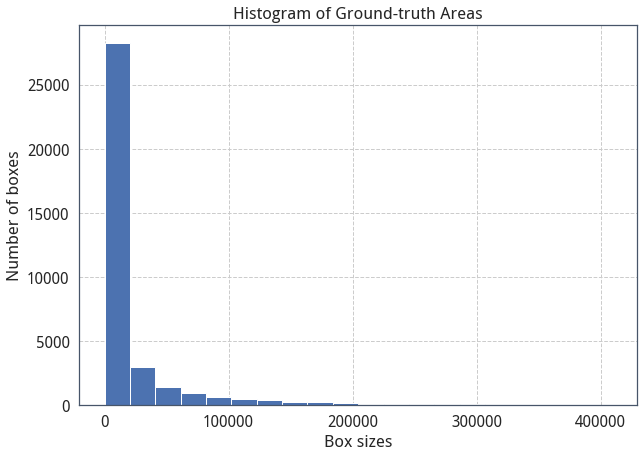

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))
df.hist(column='gt_area', bins=20, ax=ax)
ax.set_title("Histogram of Ground-truth Areas")
ax.set_xlabel("Box sizes")
ax.set_ylabel("Number of boxes")

In [35]:
print("gt_area.max = ", df[['gt_area']].max())
print("gt_area.min = ", df[['gt_area']].min())

gt_area.max =  gt_area    409094.40625
dtype: float64
gt_area.min =  gt_area    2.513361
dtype: float64


In [36]:
df[(df.paibb == 0)]

,img_id,query_id,gt_id,gt_area,paibb
228,2685,12,6,174.698975,0.0
1230,17714,22,16,1048.661987,0.0
1254,17899,97,0,573.457397,0.0
1314,18380,43,49,101.353722,0.0
1591,24021,10,18,27.407345,0.0
...,...,...,...,...,...
35569,570448,30,7,14.781487,0.0
35635,570688,69,27,142.213684,0.0
35745,571718,76,19,801.850708,0.0
35855,572678,35,14,92.040771,0.0


In [37]:
df[df.img_id == 350405]

,img_id,query_id,gt_id,gt_area,paibb
22093,350405,63,1,1397.263672,0.480373
22094,350405,82,2,34650.882812,0.591215
22095,350405,93,0,5652.080078,0.539611


### Inspect for image `82807`

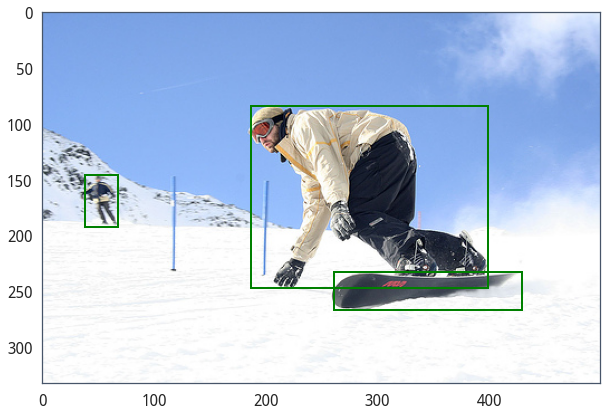

In [38]:
img_id = 350405
img = Image.open(coco_path / (f"{img_id}".rjust(12, '0') + '.jpg'))

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)
ax.grid(False)

img_annos = get_annos_for_img(img_id)
for img_anno in img_annos:
    x, y, w, h = img_anno['bbox']
    ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=2))

**Load attention for sparsemax model for this image**

In [24]:
import torch.nn.functional as F

# res = torch.load(Path(package_root) / "temp" / ("sparsemax_attns_" + f"{img_id}".rjust(12, '0') + '.pt'), map_location="cpu")
# print(res['attentions'].shape)
# # print(res['image_id'])
# # print(res['orig_size'])
# attns_t = res['attentions'].view(1, 100, 25, 27).squeeze(0)

# plt.imshow(attns_t[20].detach().cpu())
# plt.grid(False)

torch.Size([100, 25, 38])
350405
tensor([333, 500])


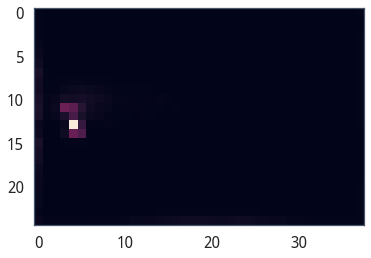

In [26]:
res = torch.load(Path(package_root) / "outputs" / "attentions" / "alpha_entmax" / (f"{img_id}".rjust(12, '0') + '.pt'), map_location="cpu")
print(res['attentions'].shape)
print(res['image_id'])
print(res['orig_size'])

plt.imshow(res['attentions'][11].detach().cpu())
plt.grid(False)

In [27]:
res['attentions'].shape[-2:]

torch.Size([25, 38])

In [28]:
img_h, img_w = res['orig_size'].unbind(-1)

h, w = res['attentions'].shape[-2:]
# B, num_queries, K = res['attentions'].shape
# assert K == w * h

attentions = F.interpolate(res['attentions'].unsqueeze(0), (img_h, img_w), mode='bilinear')
attentions.shape

torch.Size([1, 100, 333, 500])

In [29]:
attns = attentions.squeeze(0)
attns.shape

torch.Size([100, 333, 500])

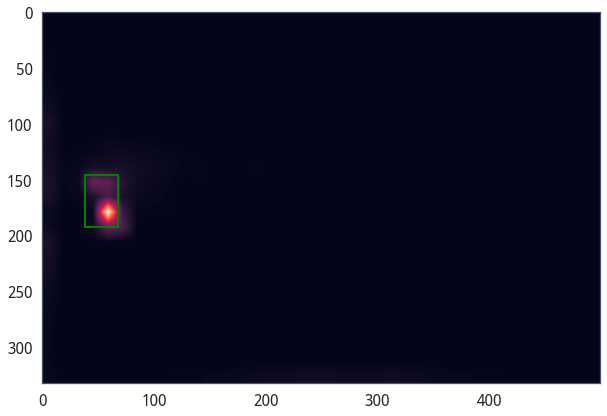

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(attns[11].detach().cpu().numpy())
ax.grid(False)

bbox = img_annos[1]['bbox']
x, y, w, h = bbox
ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=2))

In [18]:
print(x, y, w, h)

461.48 311.67 74.82 113.05


In [19]:
xmin, xmax = int(x), int(x + w)
ymin, ymax = int(y), int(y + h)
print(f"x={x}, y={y}, w={w}, h={h}")
print(f"xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")

x=461.48, y=311.67, w=74.82, h=113.05
xmin=461, ymin=311, xmax=536, ymax=424


In [20]:
attn_inside = attns[17][int(ymin):int(ymax), int(xmin):int(xmax)]
attn_inside.sum() / attns[17].sum() * 100

tensor(0.2133)

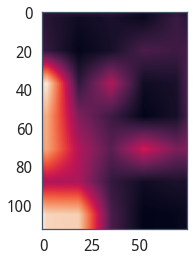

In [21]:
plt.imshow(attn_inside)
plt.grid(False)